# Predicting Student Admissions
**_Before you begin, understand the problem_**

The dataset originally came from here: http://www.ats.ucla.edu/

## Back-end Keras

In [3]:
!KERAS_BACKEND=tensorflow python -c "from keras import backend"

Using TensorFlow backend.


## Imports

In [4]:
# Data analysis and data wrangling
import numpy as np
import pandas as pd

# Plotting
import pydot
import pydotplus
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

# Machine learning
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.optimizers import SGD

# Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Other
from IPython.display import Image
import configparser
import subprocess
import warnings
import pprint
import time
import os

Using TensorFlow backend.


## Prepare Principal Directory

In [5]:
def prepare_directory_work(end_directory: str='notebooks'):
    # Current path
    curr_dir = os.path.dirname (os.path.realpath ("__file__")) 
    
    if curr_dir.endswith(end_directory):
        os.chdir('..')
        return curr_dir
    
    return f'Current working directory: {curr_dir}'

In [6]:
prepare_directory_work(end_directory='neural_networks')

'Current working directory: /home/campos/projects/artificial_inteligence/deep_learning/neural_networks/examples'

## Cell Format

In [7]:
# hide_code
# Guarantees visualization inside the jupyter
%matplotlib inline

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# Format the data os all table (float_format 3)
pd.set_option('display.float_format', '{:.6}'.format)

# Print xxxx rows and columns
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

# Pretty print
pp = pprint.PrettyPrinter(indent=4)

## Load Data
- Colunas
  - GRE Scores (Test)
  - GPA Scores (Grades)
  - Class rank (1-4)

In [8]:
%%time

data = pd.read_csv('../data/student_data.csv')
data.head()

CPU times: user 3.58 ms, sys: 0 ns, total: 3.58 ms
Wall time: 24 ms


,admit,gre,gpa,rank
0,0,380.0,3.61,3.0
1,1,660.0,3.67,3.0
2,1,800.0,4.0,1.0
3,1,640.0,3.19,4.0
4,0,520.0,2.93,4.0


In [9]:
data['admit'].unique()

array([0, 1])

Aqui, podemos ver que a primeira coluna é o target `y`, que corresponde a aceitação/rejeição. Ou seja, o label 1 significa que o aluno foi aceito e o label 0, que ele foi rejeitado.

In [10]:
data['rank'].unique()

array([ 3.,  1.,  4.,  2., nan])

A coluna `rank` diz em qual classificação o aluno ficou.

In [11]:
def plot_points(data):
    X = np.array(data[["gre","gpa"]])
    y = np.array(data["admit"])
    admitted = X[np.argwhere(y==1)]
    rejected = X[np.argwhere(y==0)]
    
    plt.scatter([s[0][0] for s in rejected], [s[0][1] for s in rejected], s = 25, color = 'red', edgecolor = 'k')
    plt.scatter([s[0][0] for s in admitted], [s[0][1] for s in admitted], s = 25, color = 'cyan', edgecolor = 'k')
    plt.xlabel('Test (GRE)')
    plt.ylabel('Grades (GPA)')

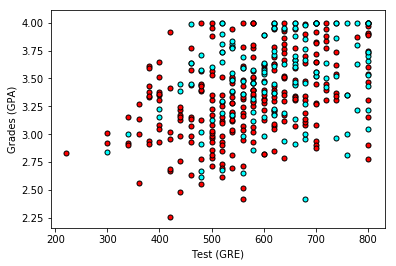

In [12]:
plot_points(data)
plt.show()

The data, based on only GRE and GPA scores, doesn't seem very separable. Maybe if we make a plot for each of the ranks, the boundaries will be more clear.

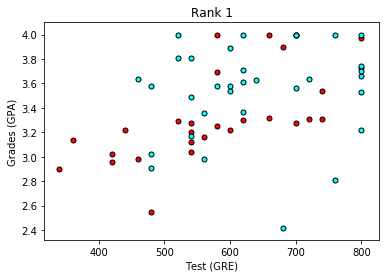

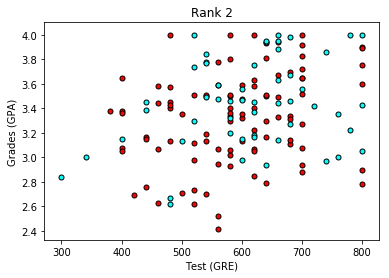

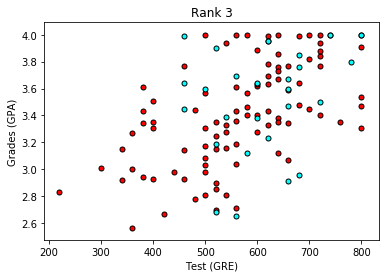

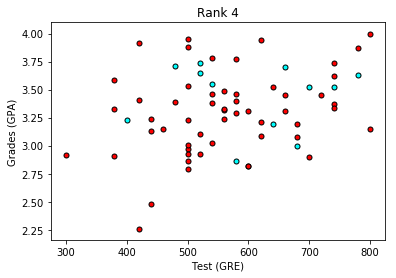

In [13]:
data_rank1 = data[data["rank"]==1]
data_rank2 = data[data["rank"]==2]
data_rank3 = data[data["rank"]==3]
data_rank4 = data[data["rank"]==4]
plot_points(data_rank1)
plt.title("Rank 1")
plt.show()
plot_points(data_rank2)
plt.title("Rank 2")
plt.show()
plot_points(data_rank3)
plt.title("Rank 3")
plt.show()
plot_points(data_rank4)
plt.title("Rank 4")
plt.show()

## Preprocessing Data

### Drop None Values

In [14]:
# fillna()
data = data.fillna(0)

Parece que, quanto melhores as notas e testes dos alunos, maior a probabilidade de eles serem aceitos. E a classificação tem alguma relação com isso. Então, o que faremos é uma codificação one-hot encode da classificação.


In [15]:
# get_dummies()
processed_data = pd.get_dummies(data, columns=['rank'])
print(processed_data.head())

   admit   gre  gpa  rank_0.0  rank_1.0  rank_2.0  rank_3.0  rank_4.0
0      0 380.0 3.61         0         0         0         1         0
1      1 660.0 3.67         0         0         0         1         0
2      1 800.0  4.0         0         1         0         0         0
3      1 640.0 3.19         0         0         0         0         1
4      0 520.0 2.93         0         0         0         0         1


### Outliers

In [16]:
data.describe()

,admit,gre,gpa,rank
count,400.0,400.0,400.0,400.0
mean,0.3175,585.1,3.37398,2.48
std,0.466087,122.587,0.448889,0.952296
min,0.0,0.0,0.0,0.0
25%,0.0,515.0,3.1275,2.0
50%,0.0,580.0,3.39,2.0
75%,1.0,660.0,3.67,3.0
max,1.0,800.0,4.0,4.0


In [17]:
def plot_box_plot(df: 'dataframe', data_set_name: str, xlim=None):
    """
    Creates a seaborn boxplot including all dependent
    
    Args:
    data_set_name: Name of title for the boxplot
    xlim: Set upper and lower x-limits
    
    Returns:
    Box plot with specified data_frame, title, and x-limits 
    """
    fig, ax = plt.subplots(figsize=(18, 10))

    if xlim is not None:
        plt.xlim(*xlim)
    
    plt.title(f"Horizontal Boxplot {data_set_name}")
        
    plt.ylabel('Dependent Variables')
    plt.xlabel('Measurement x')
    ax = sns.boxplot(data = df,
                    orient = 'h', 
                    palette = 'Set2',
                    notch = False, # box instead of notch shape 
                    sym = 'rs')  # red squares for outliers

    plt.show()

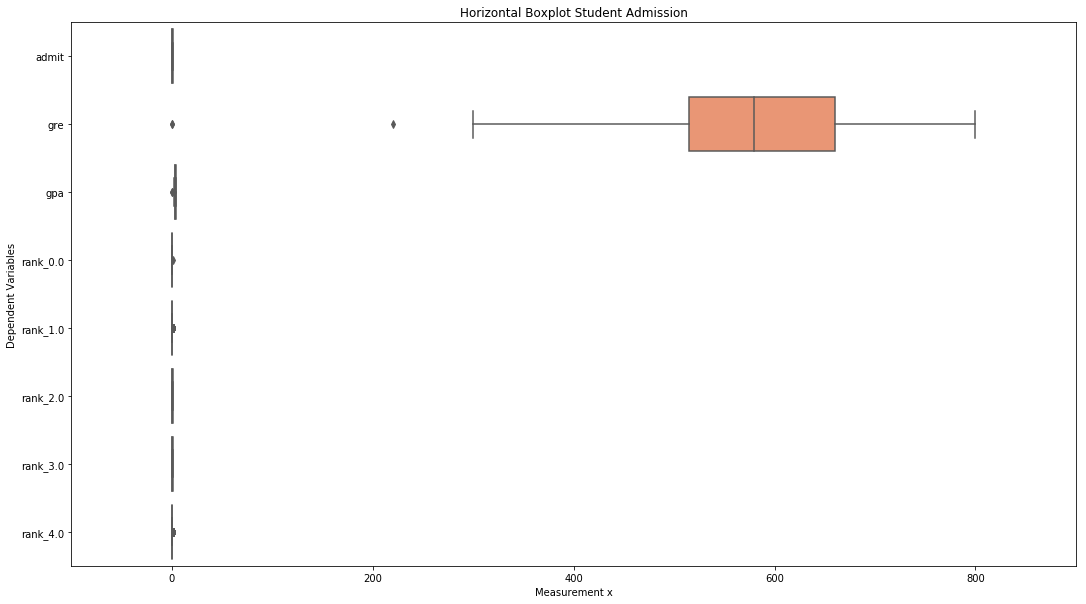

In [18]:
plot_box_plot(processed_data, 
              'Student Admission', 
              (-100, 900))

### Scaling (Normalization)

Há uma grande discrepância da features GRE(notas do testes) com as demais features e isto pode ser um fator complicador para um modelo. Por isso, será aplicado uma normalização afim de deixar os dados entre 0 e 1.
- `gre` / 800, pois o range vai até 800
- `gpa` / 4 pois o range vai até 4 

In [19]:
# Normalizing the gre and the gpa scores to be in the interval (0,1)
processed_data["gre"] = processed_data["gre"]/800
processed_data["gpa"] = processed_data["gpa"]/4

processed_data.head()

,admit,gre,gpa,rank_0.0,rank_1.0,rank_2.0,rank_3.0,rank_4.0
0,0,0.475,0.9025,0,0,0,1,0
1,1,0.825,0.9175,0,0,0,1,0
2,1,1.0,1.0,0,1,0,0,0
3,1,0.8,0.7975,0,0,0,0,1
4,0,0.65,0.7325,0,0,0,0,1


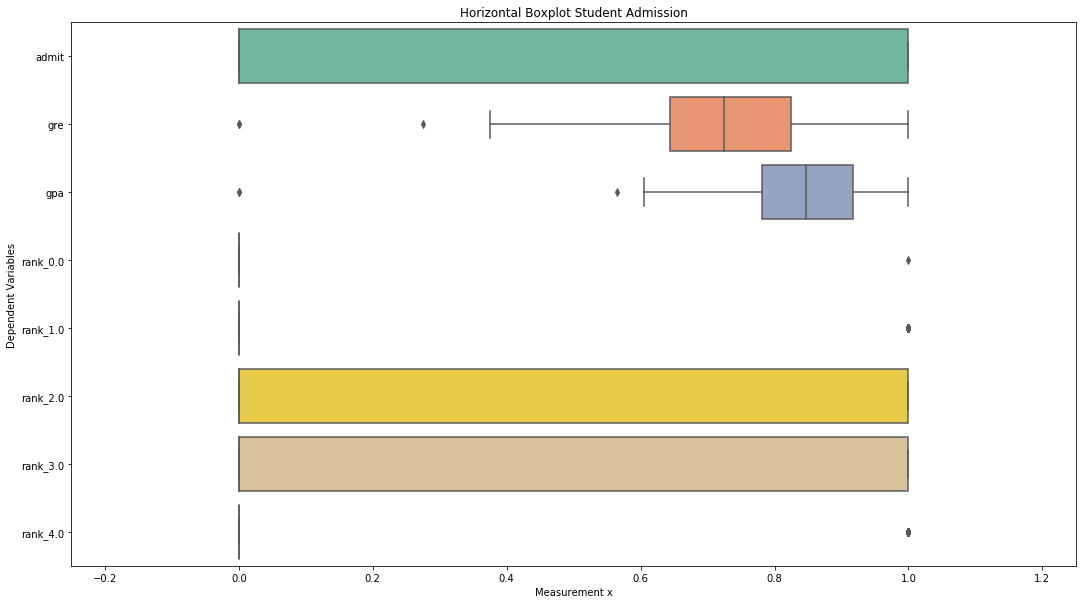

In [20]:
plot_box_plot(processed_data, 
              'Student Admission', 
              (-0.25, 1.25))

---

## Prepare Tranning

In [21]:
# Splitting the data input into X, and the labels y 
X = np.array(processed_data)[:,1:]
X = X.astype('float32')
y = keras.utils.to_categorical(data["admit"],2)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [23]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (320, 7)
Shape of y_train: (320, 2)
Shape of X_test: (80, 7)
Shape of y_test: (80, 2)


## Build Model

In [24]:
model = Sequential()

## Build Architecture
1. Input
2. Hidden
3. Output

In [25]:
model.add(Dense(128, activation='relu', input_dim=(7)))
model.add(Dropout(.1))
model.add(Dense(2, activation='softmax'))

## Compile

In [26]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Check Neural Network

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.get_config()

{'name': 'sequential_1',
 'layers': [{'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'batch_input_shape': (None, 7),
    'dtype': 'float32',
    'units': 128,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout_1',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.1,
    'noise_shape': None,
    'seed': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_2',
    'trainable': True,
    'dtype': 'float32',
    'units': 2,
    'activation': 'softmax',
    'use_bias': True,
    'kernel_initializ

## Save Model
Quando invocado a função `model.save()` é salvado em um arquivo:
- arquitetura da neural network
- weights
- configuração do treinamento

In [39]:
keras_model_path = "/tmp/predict_student_admissions.pkl"
model.save(keras_model_path)

## Train Modal

In [29]:
history = model.fit(X_train,
                    y_train,
                    epochs=200,
                    batch_size=100,
                    verbose=0,
                    validation_split=0.2,
                    shuffle=True)

history

### Show Tranning

In [27]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


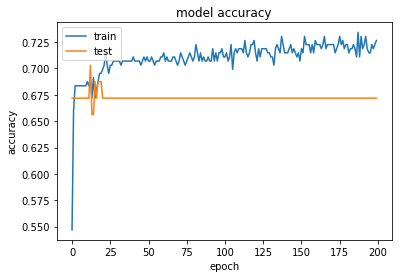

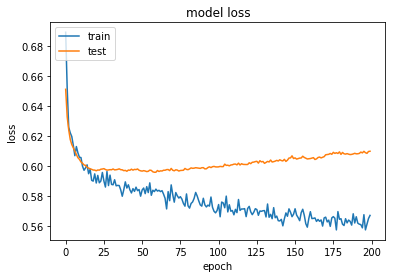

In [30]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluation

In [31]:
score = model.evaluate(X_train, y_train)
print("\n Training Accuracy:", score[1])
score = model.evaluate(X_test, y_test)
print("\n Testing Accuracy:", score[1])

320/320 [==============================] - 0s 23us/step

 Training Accuracy: 0.7124999761581421
80/80 [==============================] - 0s 42us/step

 Testing Accuracy: 0.699999988079071


---